In [1]:
import numpy
import scipy
import scipy.special
import scipy.stats
from sklearn import metrics
import matplotlib.pyplot as plt
import rmi.pp, rmi.map, rmi.em
from rmi.xdist import xexpon, xgamma
%load_ext ipython_unittest
%matplotlib inline

# Intrusions in Marked Renewal Processes

This notebook is a part of empirical evaluation for the paper [](Intrusions in Marked Renewal Processes). 


## Helpers

We need an improper uniform distribution with pdf equal 1 everywhere. We will use it to ignore either marks or intervals for intrusion detection.

In [35]:
class ImproperUniform(object):
    """Improper uniform distribution.
    pdf, cdf, and sf is 1 everywhere.
    """
    def pdf(self, _):
        return 1
    
    def cdf(self, _):
        return 1
    
    @property
    def meanpdf(self):
        return 1
    
    def if2(self, _):
        return 1
    
    def ixf2(self, _):
        return 1
    
    def mean(self):
        return 1

## Evaluation on Synthetic data

Synthetic data are sampled from a marked renewal process of known shape and parameters. 

### Generative model

We first define a generative model for the data in Python. The model produces both normal entries and intrusions.

In [36]:
def generate(N, pi, F, G, Gi=xexpon(scale=1)):
    """
    Generates a data sequence with possible intrusion.
    Accepts:
        N - the number of events,
        F - interval distribution,
        G - mark distribution,
        Gi - intrusion mark distribution.
    Returns:
        [t_s, t_e, [[t_i, y_i] ...], [z_i ...]]
    where
        t_s - start of the interval
        t_e - end of the interval
        t_i - arrival time of the ith event
        y_i - mark of the ith event
        z_i - 1 if the event belongs to the intrusion, 0 otherwise.
    """
    # Normal events
    K = scipy.stats.binom.rvs(N, pi)
    ts = numpy.cumsum(F.rvs(size=N - K))
    ys = G.rvs(size=N - K)
    t_s = scipy.stats.uniform.rvs(0, ts[0])
    t_e = ts[-1] + t_s
    
    # Intrusion events
    ti_s, ti_e = scipy.stats.uniform.rvs(t_s, t_e - t_s, size=2)
    if ti_e < ti_s:
        ti_s, ti_e = ti_e, ti_s
    tis = scipy.stats.uniform.rvs(ti_s, ti_e - ti_s, size=K)
    yis = Gi.rvs(size=K)
    
    # Merge them into a single list
    SZ = [(t, s, 0) for t, s in zip(ts, ys)] + [(t, s, 1) for t, s in zip(tis, yis)]
    SZ.sort(key=lambda x: x[0])
    S = [(x, y) for x, y, _ in SZ]
    Z = [z for _, _, z in SZ]
    return [t_s, t_e, S, Z]

The event probability of belonging to an intrusion is chosen so that the probability of an intrusion is as given.

In [37]:
def get_pe(N, p=0.5):
    """"""
    return 1 - (1 - p)**(1. / N)

In [ ]:
%%unittest
"""Check that generated data set is balanced as specified"""
for pi in [0.25, 0.5, 0.75]:
    assert abs(scipy.stats.binom.pmf(0, 100, get_pe(100, pi)) - (1 - pi)) < 1E-6

In [ ]:
%%unittest
"""check that traces contain intrusion with requested probability"""
N = 100
pi = 0.5
pe = get_pe(N, pi)
NITER = 1000
ind = 0
for i in range(NITER):
    t_s, t_e, S, Z = generate(N, pe, 
        F=scipy.stats.gamma(a=2, scale=1), 
        G=scipy.stats.expon(scale=1),
        Gi=scipy.stats.expon(scale=10))
    ind += any(Z)
assert abs(ind/NITER - pi) < 0.05

### Evaluation dataset

We can generate a data set using the generative model now. The data consists of tensors `T`, `S`, and `Z` containing intervals, samples and labels for the samples, correspondingly. 

In [104]:
NSAMPLES = 10000
FAs = [1, 2, 4, 8, 16]
FSCALE = 1.
GSCALE = 1.
ISCALE = 2.
N = 20
PI = 0.5
PE = get_pe(N, PI)

def sfname(t, p):
    return format("../data/x-{}-synthetic-a={}.npy".format(t, a))

In [ ]:
GENERATE = True
if GENERATE:
    print("a")
    for a in FAs:
        print("{:f}".format(a), end=" ")
        T = []
        S = []
        Z = []
        # We create a balanced data set here, otherwise
        # positive samples will be too sparse for realistic
        # values of P
        for i in range(NSAMPLES):
            while True:
                t_s, t_e, s, z = generate(N, PE, 
                    F=scipy.stats.gamma(a=a, scale=FSCALE), 
                    G=scipy.stats.expon(scale=GSCALE),
                    Gi=scipy.stats.expon(scale=ISCALE))
                if (sum(z) == 0) == (numpy.random.rand() < PI):
                    break
            T.append([t_s, t_e])
            S.append(s)
            Z.append(z)
        T = numpy.array(T)
        S = numpy.array(S)
        Z = numpy.array(Z)
        numpy.save(sfname("t", a), T, False)
        numpy.save(sfname("s", a), S, False)
        numpy.save(sfname("z", a), Z, False)
        print("✓")

For analysis, we re-load the dataset. The dataset is a list of records, one record for each `a`.

In [106]:
DATASETS = []
SUBSIZE = None
for a in FAs:
        T = numpy.load(sfname("t", a))
        S = numpy.load(sfname("s", a))
        Z = numpy.load(sfname("z", a))
        if SUBSIZE is not None:
            T = T[:SUBSIZE]
            S = S[:SUBSIZE]
            Z = Z[:SUBSIZE]
        DATASETS.append({"a": a,
                         "T": T,
                         "S": S,
                         "Z": Z})

With the dataset at hand, we are ready for the evaluation.

### Experiments with algorithms

#### Posterior Probabilities

In [107]:
def posteriors(ds, EM, F, G, pe, masks=["F", "G", ""]):
    for mask in masks:
        P = numpy.ndarray(ds["S"].shape[0])
        M = numpy.ndarray(ds["S"].shape[:2])
        L = numpy.ndarray(M.shape)
        
        for i in range(ds["S"].shape[0]):
            S = ds["S"][i, :]
            t_s, t_e = ds["T"][i, :]

            if EM:
                F_, G_, _ = rmi.em.parameters(t_s, t_e, S, pe, max_iter=10)
            else:
                F_, G_ = F, G
            
            if mask == "F":
                F_ = ImproperUniform()
            elif mask == "G":
                G_ = ImproperUniform()

            P[i] = rmi.pp.intrusion(t_s, t_e, S, pe, F_, G_)
            M[i, :] = rmi.pp.marginal(t_s, t_e, S, pe, F_, G_)
            L[i, :] = rmi.map.labels(t_s, t_e, S, pe, F_, G_)
            
        # probability computations may overflow
        P[numpy.isnan(P)] = 0.5
        M[numpy.isnan(M)] = 0.5
        
        ds["P" + str(EM) + mask] = P
        ds["M" + str(EM) + mask] = M
        ds["L" + str(EM) + mask] = L

Let's now compute posteriors for all samples in all data sets.

In [ ]:
MASKS = ["G"]

G = xexpon(scale=GSCALE)
print("EM\ta")
for ds in DATASETS:
    F = xgamma(a=ds["a"], scale=FSCALE)
    for EM in [False, True]:
        print("{}\t{:.4f}".format(EM, ds["a"]), end=" ")
        posteriors(ds, EM, F, G, PE, MASKS)
        print("✓")

Based on the computed results, we can obtain statistics on intrusion detection.

#### Basic analytics

First, we compute just the average intrusion probability in positive and negative samples. The greater the difference between these two numbers, the higher is the detection accuracy.

In [ ]:
print("EM\tmask\ta\tnP\tpP\tnN\tpN")
as_ = set()
curves = {}
for ds in DATASETS:
    for mask in MASKS:
        for EM in ["False", "True"]:
            pP = 0.
            pP2 = 0.
            pN = 0.
            pN2 = 0.
            nP = 0
            nN = 0
            for i in range(ds["S"].shape[0]):
                if sum(ds["Z"][i, :]) > 0:
                    pi = ds["P" + EM + mask][i]
                    pP += pi
                    pP2 += pi * pi
                    nP += 1
                else:
                    pi = ds["P" + EM + mask][i]
                    pN += pi
                    pN2 += pi * pi
                    nN += 1
            pP /= max(nP, 1)
            pN /= max(nN, 1)
            pP2 /= max(nP, 1)
            pN2 /= max(nN, 1)
            as_.add(ds["a"])
            if (EM + mask) not in curves:
                curves[EM + mask]  = {}
            curves[EM + mask][ds["a"]] = [pP, pN,
                                   numpy.sqrt(pP2 - pP * pP),
                                   numpy.sqrt(pN2 - pN * pN)]
            print("{}\t{}\t{:.4f}\t{:d}\t{:.4f}\t{:d}\t{:.4f}"
                  .format(EM, mask, ds["a"], nP, pP, nN, pN))
as_ = sorted(list(as_))

Let's visualize the average alert score as function of intrusion probability.

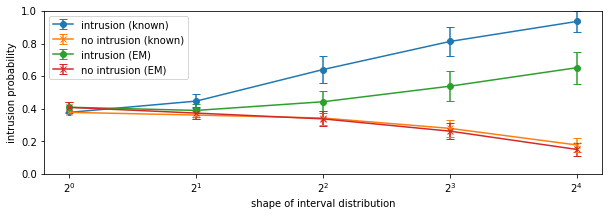

In [119]:
xs = as_
f_s_aas, sp = plt.subplots(1, 1, sharex=True, sharey=True)
f_s_aas.set_figwidth(10)
f_s_aas.set_figheight(3)
sp.set_ylabel("intrusion probability")
sp.set_xlabel("shape of interval distribution")
sp.set_ylim(0, 1.)
sp.semilogx(basex=2)
for j, mask in enumerate(MASKS):
    for em, label in [(False, "known"), (True, "EM")]:
        ys = numpy.array([curves[str(em) + mask][a] for a in as_])
        sp.errorbar(xs, ys[:, 0], yerr=ys[:, 2], marker='o', capsize=4, label="intrusion ({})".format(label))
        sp.errorbar(xs, ys[:, 1], yerr=ys[:, 3], marker='x', capsize=4, label="no intrusion ({})".format(label))
    handles, labels = sp.get_legend_handles_labels()
sp.legend(handles, labels, loc="upper left")
# f_s_aas.savefig('../figures/synthetic-intrusion-probability.pdf')

#### Fine-grained metrics

We also obtain more fine-grained metrics of detection accuracy. 

* AUC on total intrusion probability
* Jackard similarity for MAP

#### AUC

In [ ]:
print("EM\tmask\ta\tauc")
pcurves = {}
f, sp = plt.subplots(1, 2, sharey=True)
f.set_figwidth(15)
f.set_figheight(3)
sp[0].set_xlabel("FPR")
sp[0].set_ylabel("TPR")
sp[1].set_xlabel("Recall")
sp[1].set_ylabel("Precision")
for ds in DATASETS:
    for EM in [False, True]:
        print("{}\t{}\t{:.4f}"
                  .format(EM, mask, ds["a"]), end="")
        for mask in MASKS:
            key = str(EM) + mask
            fpr, tpr, thresholds = metrics.roc_curve(ds["Z"].sum(axis=1) > 0,
                                                     ds["P" + key], 
                                                     pos_label=True)
            precision, recall, thresholds = metrics.precision_recall_curve(
                                                     ds["Z"].sum(axis=1) > 0,
                                                     ds["P" + key],
                                                     pos_label=True)
            sp[0].plot(fpr, tpr)
            sp[1].plot(recall, precision)
            auc = metrics.auc(fpr, tpr)
            if key not in pcurves:
                pcurves[key] = {}
            pcurves[key][ds["a"]] = auc
            print("\t{:.4f}".format( auc), end="")
        print()

Let's visualize AUC:

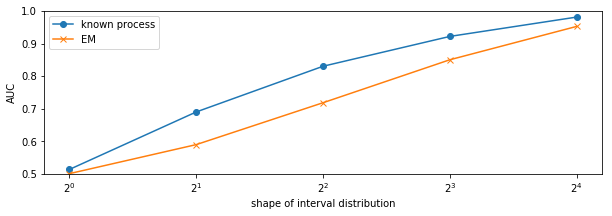

In [112]:
xs = as_
f_s_pauc, sp = plt.subplots(1, 1, sharex=True, sharey=True)
f_s_pauc.subplots_adjust(wspace=0.05, hspace=0.05)
f_s_pauc.set_figwidth(10)
f_s_pauc.set_figheight(3)
sp.set_ylabel("AUC")
sp.set_xlabel("shape of interval distribution")
sp.set_ylim(0.5, 1.)
sp.semilogx(basex=2)
for mask in MASKS:
    for (i, em) in enumerate(["False", "True"]):
        ys = numpy.array([pcurves[em + mask][a] for a in as_])
        sp.plot(xs, ys, label=["known process", "EM"][i], marker=['o', 'x'][i])
sp.legend()
# f_s_pauc.savefig("../figures/synthetic-auc-per-entry.pdf")

#### Jaccard similarity

In [113]:
print("EM\ta\tjss")
jcurves = {}
for ds in DATASETS:
    for EM in [False, True]:
        print("{}\t{:.4f}".format(EM, ds["a"]), end="")
        for mask in MASKS:
            key = str(EM) + mask
            jss = metrics.jaccard_similarity_score(ds["Z"], ds["L" + key])
            if key not in jcurves:
                jcurves[key] = {}
            jcurves[key][ds["a"]] = jss
            print("\t{:.4f}".format(jss), end="")
        print()

EM	a	jss
False	1.0000	0.4990
True	1.0000	0.4879
False	2.0000	0.4956
True	2.0000	0.4853
False	4.0000	0.5594
True	4.0000	0.5058
False	8.0000	0.6920
True	8.0000	0.5641
False	16.0000	0.7940
True	16.0000	0.6095


Let's visualize Jaccard score:

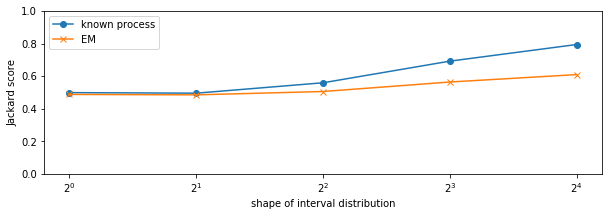

In [114]:
xs = as_
f_s_pauc, sp = plt.subplots(1, 1, sharex=True, sharey=True)
f_s_pauc.subplots_adjust(wspace=0.05, hspace=0.05)
f_s_pauc.set_figwidth(10)
f_s_pauc.set_figheight(3)
sp.set_ylabel("Jackard score")
sp.set_xlabel("shape of interval distribution")
sp.set_ylim(0., 1.)
sp.semilogx(basex=2)
for mask in MASKS:
    for (i, em) in enumerate(["False", "True"]):
        ys = numpy.array([jcurves[em + mask][a] for a in as_])
        sp.plot(xs, ys, label=["known process", "EM"][i], marker=['o', 'x'][i])
sp.legend()
# f_s_jss.savefig("../figures/synthetic-jaccard-score.pdf")

## Evaluation on anonymized real-world data

In [78]:
def cfname(t, intr):
    return format("../data/{}-collected-{}.npy".format(t, intr))

The dataset as given is split into positive and negative samples. We load the dataset and concatenate both parts.

In [79]:
Ss = []
Zs = []
for intr in ["negative", "positive"]:
    Ss.append(numpy.load(cfname("s", intr)))
    Zs.append(numpy.load(cfname("z", intr)))
ds = {}
ds["S"] = numpy.concatenate(Ss, axis=0)
ds["Z"] = numpy.concatenate(Zs, axis=0)
ds["T"] = numpy.array([[0., 1.]] * ds["S"].shape[0])
assert ds["S"].shape[0] == ds["Z"].shape[0]

We shuffle samples in the data set and split it into the training and testing data set. We will use the training dataset to estimate prior probability of intrusion.

In [90]:
NSAMPLES, N, _ = ds["S"].shape
TRAIN_FRACTION = 5

indices = numpy.array(range(NSAMPLES))
numpy.random.shuffle(indices)

ds["S"] = ds["S"][indices]
ds["Z"] = ds["Z"][indices]

print("{} samples, {} time points per sample".format(NSAMPLES, N))

train_indices = indices[:len(indices) // TRAIN_FRACTION]
test_indices = indices[len(indices) // TRAIN_FRACTION:]

ds_train = {}
ds_test = {}
for key in ["S", "Z", "T"]:
    ds_train[key] = ds[key][train_indices]
    ds_test[key] = ds[key][test_indices]

1000 samples, 50 time points per sample


In [ ]:
print("pi\tpauc\tmauc\tjss")
f, plot = plt.subplots(1, 1)
plot.set_xlabel("FPR")
plot.set_ylabel("TPR")
maxauc = 0.
pibest = 0.
for pi in [0.05, 0.1, 0.2, 0.4]:
    pe = get_pe(ds_train["S"].shape[1], pi)
    posteriors(ds_train, EM=True, F=None, G=None, pe=pe, masks=[""])
    fpr, tpr, thresholds = metrics.roc_curve(ds_train["Z"].sum(axis=1) > 0,
                                             ds_train["PTrue"], 
                                             pos_label=True)
    pauc = metrics.auc(fpr, tpr)
    plot.plot(fpr, tpr, c='blue', label='per entry')

    fpr, tpr, thresholds = metrics.roc_curve(ds_train["Z"].reshape(-1) > 0,
                                             ds_train["MTrue"].reshape(-1), 
                                             pos_label=True)
    mauc = metrics.auc(fpr, tpr)
    plot.plot(fpr, tpr, c='orange', label='per event')

    jss = metrics.jaccard_similarity_score(ds_train["Z"], ds_train["LTrue"])

    print("{:.4f}\t{:.4f}\t{:.4f}\t{:4f}".format(pi, pauc, mauc, jss))
    
    if mauc*pauc > maxauc:
        pibest = pi
        maxauc = mauc*pauc
 
print("pibest = {:.4f}".format(pibest))

handles, labels = plot.get_legend_handles_labels()
plot.legend(handles[-2:], labels[-2:])

We chose $p$, the prior intrusion probability, to maximize the AUC. With $p$ chosen, we  evaluate the algorithm on the test dataset. 

In [91]:
posteriors(ds_test, EM=True, F=None, G=None, pe=get_pe(N, pibest))

          AUC per entry    AUC per event    Jaccard score  
I             0.6925           0.8760           0.5646     
M             0.6005           0.7622           0.5180     
MI            0.7151           0.9130           0.5766     


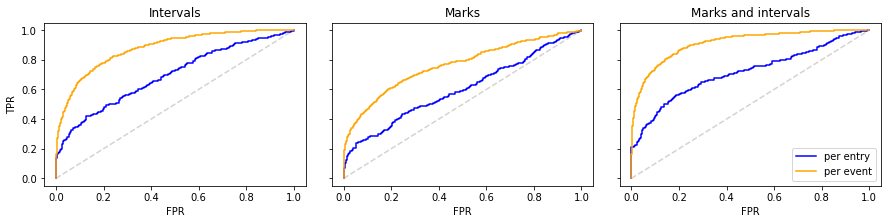

In [92]:
f_a_roc, sps = plt.subplots(1, 3, sharey=True)
f_a_roc.set_figheight(3)
f_a_roc.set_figwidth(15)
f_a_roc.subplots_adjust(wspace=0.1)
sps[0].set_ylabel("TPR")
sps[0].set_title("Intervals")
sps[1].set_title("Marks")
sps[2].set_title("Marks and intervals")
print(("{:8s}" + "".join([" {:^16s}"] * 3))
      .format("", "AUC per entry", "AUC per event", "Jaccard score"))
for i, (mask, label) in enumerate([("G", "I"), ("F", "M"), ("", "MI")]):
    sps[i].set_xlabel("FPR")

    fpr, tpr, thresholds = metrics.roc_curve(ds_test["Z"].sum(axis=1) > 0,
                                             ds_test["PTrue" + mask], 
                                             pos_label=True)
    pauc = metrics.auc(fpr, tpr)
    sps[i].plot(fpr, fpr, '--', c='lightgray')
    sps[i].plot(fpr, tpr, c='blue', label='per entry')

    fpr, tpr, thresholds = metrics.roc_curve(ds_test["Z"].reshape(-1) > 0,
                                             ds_test["MTrue" + mask].reshape(-1), 
                                             pos_label=True)
    mauc = metrics.auc(fpr, tpr)
    sps[i].plot(fpr, tpr, c='orange', label='per event')

    jss = metrics.jaccard_similarity_score(ds_test["Z"], ds_test["LTrue" + mask])

    print(("{:8s}" + "".join([" {:^16.4f}"] * 3))
          .format(label, pauc, mauc, jss))
sps[2].legend()
# f_a_roc.savefig("../figures/anonymized-roc.pdf")